# Measuring changes in polarisation using Singular Value Decomposition of Random Dot Product Graphs
 
Article: https://networksci.peercommunityin.org/articles/rec?id=217
 
**Data folder structure:**
- `data/1/`: Contains daily files. Each file covers a single day, from 00:00 of one day to 00:00 of the next.
- `data/2/`: Contains cumulative files. Each file starts at 2025-02-23 and ends at the date specified in the filename.
- `data/3/`: Contains files for 12-hour intervals. Each file covers a period from a start date and time to an end date and time, both specified in the filename in UTC.


In [1]:
import pathlib
import polars as pl
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import re
from scipy.stats import norm

# Methods to calculate svd
from numpy.linalg import svd
from scipy.sparse.linalg import svds
from sklearn.utils.extmath import randomized_svd

In [17]:
DATA_PATH = "../data/1/"
DATA_FILES = sorted(pathlib.Path(DATA_PATH).glob("*.csv"))

mapping_nodes_with_zero_degree = {}
graphs = {}

for file in DATA_FILES:
    df = pd.read_csv(file, index_col=0)
    
    # Remove self-loops (Testing purposes)
    np.fill_diagonal(df.values, 0)
    
    # Calculate node degrees to identify zero-degree nodes
    node_degrees = df.sum(axis=1) + df.sum(axis=0)
    
    # Identify nodes with zero degree
    zero_degree_nodes = node_degrees[node_degrees == 0].index.tolist()
    mapping_nodes_with_zero_degree[file.stem] = zero_degree_nodes
    
    # Remove zero-degree nodes from the adjacency matrix
    df = df.drop(index=zero_degree_nodes, columns=zero_degree_nodes)
    
    G = nx.from_pandas_adjacency(df, create_using=nx.DiGraph)
    graphs[file.stem] = G

mapping = pl.DataFrame({
    "file": list(mapping_nodes_with_zero_degree.keys()),
    "zero_degree_nodes_count": [len(nodes) for nodes in mapping_nodes_with_zero_degree.values()]
})

print(f"Graphs loaded: {len(graphs)}")
print(f"First graph: {list(graphs.keys())[0]}")
print(f"Last graph: {list(graphs.keys())[-1]}")

mapping.describe()

Graphs loaded: 52
First graph: 2025-02-23_2025-02-24
Last graph: 2025-04-15_2025-04-16


statistic,file,zero_degree_nodes_count
str,str,f64
"""count""","""52""",52.0
"""null_count""","""0""",0.0
"""mean""",null,775.5
"""std""",null,491.201548
"""min""","""2025-02-23_2025-02-24""",10.0
"""25%""",null,408.0
"""50%""",null,636.0
"""75%""",null,1057.0
"""max""","""2025-04-15_2025-04-16""",2158.0


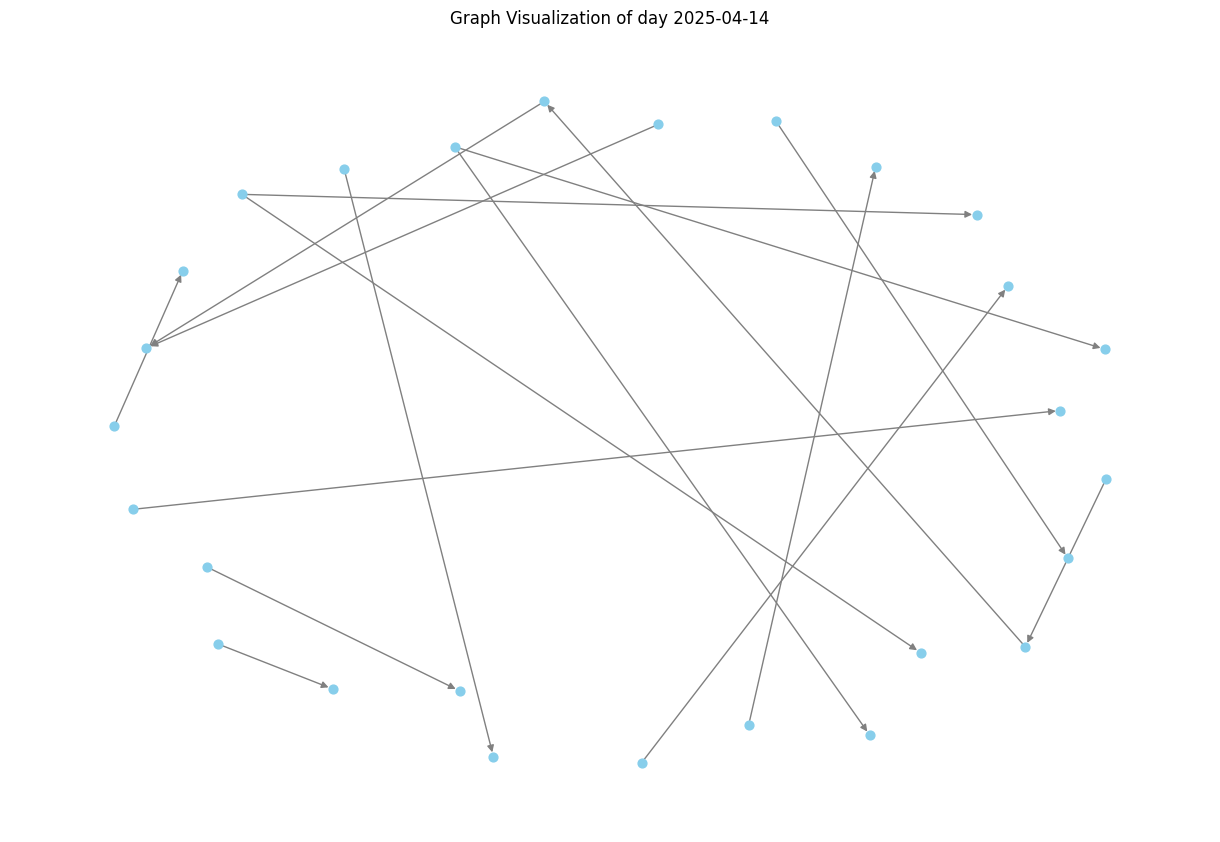

In [23]:
graph_index = 50
graph = list(graphs.values())[graph_index]
title = list(graphs.keys())[graph_index].split("_")[0]

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(graph, k=6, seed=32)
nx.draw(graph, pos, with_labels=False, node_size=40, arrowsize=10, node_color='skyblue', edge_color='gray')
plt.title(f"Graph Visualization of day {title}")
plt.show()

In [5]:
# Computes the full SVD of matrix A and returns the top k singular values.
def truncated_svd(A, k=None):
    S = svd(A, compute_uv=False, full_matrices=False)
    if k is None:
        k = len(S)
    S_k = S[:k]
    return S_k

# Estimate the embedding dimension using a likelihood-based method
def embedding_dimension(singular_values, k=None):
    if k is None:
        k = len(singular_values)
    
    sv = np.array(singular_values[:k])
    p = len(sv) 
    
    best_ll = -np.inf
    d_hat = 1

    for q in range(1, p):
        S1 = sv[:q]
        S2 = sv[q:]

        if len(S2) == 0:
            continue
            
        mu1 = np.mean(S1)
        mu2 = np.mean(S2)
        
        if len(S1) > 1:
            s1_squared = np.var(S1, ddof=1)  
        else:
            s1_squared = 0
            
        if len(S2) > 1:
            s2_squared = np.var(S2, ddof=1)
        else:
            s2_squared = 0
    
        if p <= 2:
            continue  
            
        sigma2 = ((q-1) * s1_squared + (p-q-1) * s2_squared) / (p-2)
        
        if sigma2 <= 0:
            continue

        ll = 0

        for d_i in S1:
            ll += norm.logpdf(d_i, mu1, np.sqrt(sigma2))

        for d_j in S2:
            ll += norm.logpdf(d_j, mu2, np.sqrt(sigma2))

        if ll > best_ll:
            best_ll = ll
            d_hat = q
    
    return d_hat

In [6]:
# Extract available date strings from graph keys
date_strings = sorted(list(set([re.search(r'(\d{4}-\d{2}-\d{2})', key).group(1) for key in graphs.keys()]))) # type: ignore
print(f"Available dates: {date_strings}")

Available dates: ['2025-02-23', '2025-02-24', '2025-02-25', '2025-02-26', '2025-02-27', '2025-02-28', '2025-03-01', '2025-03-02', '2025-03-03', '2025-03-04', '2025-03-05', '2025-03-06', '2025-03-07', '2025-03-08', '2025-03-09', '2025-03-10', '2025-03-11', '2025-03-12', '2025-03-13', '2025-03-14', '2025-03-15', '2025-03-16', '2025-03-17', '2025-03-18', '2025-03-19', '2025-03-20', '2025-03-21', '2025-03-22', '2025-03-23', '2025-03-24', '2025-03-25', '2025-03-26', '2025-03-27', '2025-03-28', '2025-03-29', '2025-03-30', '2025-03-31', '2025-04-01', '2025-04-02', '2025-04-03', '2025-04-04', '2025-04-05', '2025-04-06', '2025-04-07', '2025-04-08', '2025-04-09', '2025-04-10', '2025-04-11', '2025-04-12', '2025-04-13', '2025-04-14', '2025-04-15']


In [7]:
print(embedding_dimension(truncated_svd(nx.adjacency_matrix(list(graphs.values())[0]).todense())))

2


In [8]:
# Create graphs by windowed dates

def measure_polarization(graphs, steps=1, accum=False):
    embedded_dimensions = []
    window_dates = []
    
    # Iterate over date strings in windows
    for i in range(0, len(date_strings) - steps + 1, steps):
        start_date = date_strings[0] if accum else date_strings[i]
        end_date = date_strings[i + steps - 1]
        
        window_graphs = []
        for name, graph in graphs.items():
            graph_date = re.search(r'(\d{4}-\d{2}-\d{2})', name).group(1) # type: ignore
            if start_date <= graph_date <= end_date:
                window_graphs.append(graph)

        if not window_graphs:
            raise ValueError(f"No graphs found in the date range {start_date} to {end_date}")
        
        # Combine graphs in the window
        if len(window_graphs) > 1:
            combined_graph = nx.compose_all(window_graphs)
            
            # Print if there are isolated nodes in the combined graph (it should not happen)
            isolated_nodes = list(nx.isolates(combined_graph))
            if isolated_nodes:
                print(f"Isolated nodes found in combined graph from {start_date} to {end_date}: {isolated_nodes}")
        else:
            combined_graph = window_graphs[0]
        
        adj_matrix = nx.adjacency_matrix(combined_graph).todense()
        sv = truncated_svd(adj_matrix)
        d_hat = embedding_dimension(sv)
        
        if accum:
            print(f"Accumulated Window up to {end_date}: Estimated embedding dimension = {d_hat}")
        else:
            print(f"Window {start_date}: Estimated embedding dimension = {d_hat}")
        
        embedded_dimensions.append(d_hat)
        window_dates.append((start_date, end_date))
        
    return embedded_dimensions, window_dates

In [79]:
ed_1day_accum = measure_polarization(graphs, steps=1, accum=True)
print(ed_1day_accum)

Accumulated Window up to 2025-02-23: Estimated embedding dimension = 2
Accumulated Window up to 2025-02-24: Estimated embedding dimension = 34
Accumulated Window up to 2025-02-25: Estimated embedding dimension = 245
Accumulated Window up to 2025-02-26: Estimated embedding dimension = 271
Accumulated Window up to 2025-02-27: Estimated embedding dimension = 397
Accumulated Window up to 2025-02-28: Estimated embedding dimension = 542
Accumulated Window up to 2025-03-01: Estimated embedding dimension = 664
Accumulated Window up to 2025-03-02: Estimated embedding dimension = 675
Accumulated Window up to 2025-03-03: Estimated embedding dimension = 702
Accumulated Window up to 2025-03-04: Estimated embedding dimension = 777
Accumulated Window up to 2025-03-05: Estimated embedding dimension = 835
Accumulated Window up to 2025-03-06: Estimated embedding dimension = 932
Accumulated Window up to 2025-03-07: Estimated embedding dimension = 943
Accumulated Window up to 2025-03-08: Estimated embeddi

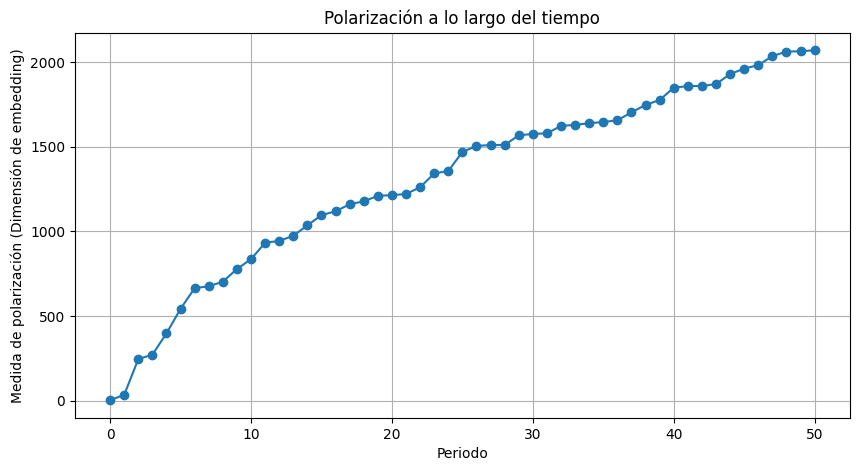

In [80]:
plt.figure(figsize=(10, 5))
plt.plot(ed_1day_accum[0], marker='o')
plt.xlabel('Periodo')
plt.ylabel('Medida de polarización (Dimensión de embedding)')
plt.title('Polarización a lo largo del tiempo')
plt.grid(True)
plt.show()

In [81]:
ed_1day = measure_polarization(graphs, steps=1, accum=False)
print(ed_1day)

Window 2025-02-23: Estimated embedding dimension = 2
Window 2025-02-24: Estimated embedding dimension = 34
Window 2025-02-25: Estimated embedding dimension = 212
Window 2025-02-26: Estimated embedding dimension = 27
Window 2025-02-27: Estimated embedding dimension = 136
Window 2025-02-28: Estimated embedding dimension = 159
Window 2025-03-01: Estimated embedding dimension = 140
Window 2025-03-02: Estimated embedding dimension = 17
Window 2025-03-03: Estimated embedding dimension = 34
Window 2025-03-04: Estimated embedding dimension = 102
Window 2025-03-05: Estimated embedding dimension = 71
Window 2025-03-06: Estimated embedding dimension = 127
Window 2025-03-07: Estimated embedding dimension = 18
Window 2025-03-08: Estimated embedding dimension = 44
Window 2025-03-09: Estimated embedding dimension = 95
Window 2025-03-10: Estimated embedding dimension = 77
Window 2025-03-11: Estimated embedding dimension = 33
Window 2025-03-12: Estimated embedding dimension = 72
Window 2025-03-13: Esti

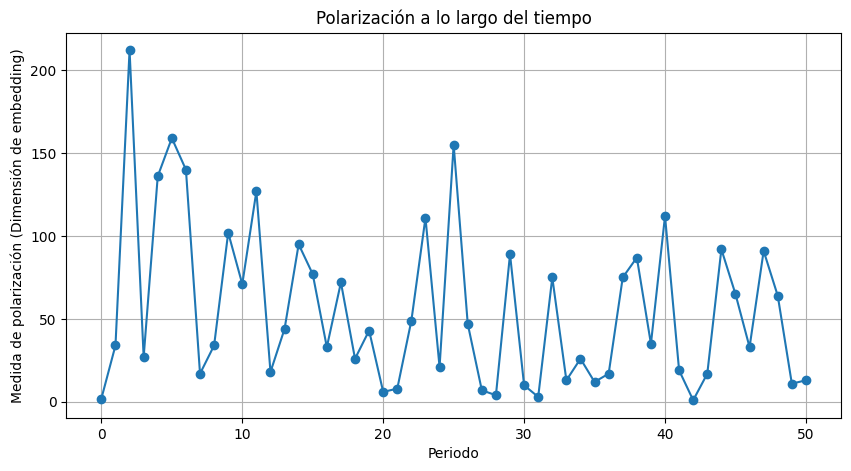

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(ed_1day[0], marker='o')
plt.xlabel('Periodo')
plt.ylabel('Medida de polarización (Dimensión de embedding)')
plt.title('Polarización a lo largo del tiempo')
plt.grid(True)
plt.show()

In [9]:
ed_3day = measure_polarization(graphs, steps=3, accum=False)
print(ed_3day)

Window 2025-02-23: Estimated embedding dimension = 245
Window 2025-02-26: Estimated embedding dimension = 317
Window 2025-03-01: Estimated embedding dimension = 186
Window 2025-03-04: Estimated embedding dimension = 285
Window 2025-03-07: Estimated embedding dimension = 154
Window 2025-03-10: Estimated embedding dimension = 178
Window 2025-03-13: Estimated embedding dimension = 73
Window 2025-03-16: Estimated embedding dimension = 168
Window 2025-03-19: Estimated embedding dimension = 220
Window 2025-03-22: Estimated embedding dimension = 101
Window 2025-03-25: Estimated embedding dimension = 87
Window 2025-03-28: Estimated embedding dimension = 51
Window 2025-03-31: Estimated embedding dimension = 174
Window 2025-04-03: Estimated embedding dimension = 159
Window 2025-04-06: Estimated embedding dimension = 108
Window 2025-04-09: Estimated embedding dimension = 183
Window 2025-04-12: Estimated embedding dimension = 83
([245, 317, 186, 285, 154, 178, 73, 168, 220, 101, 87, 51, 174, 159, 

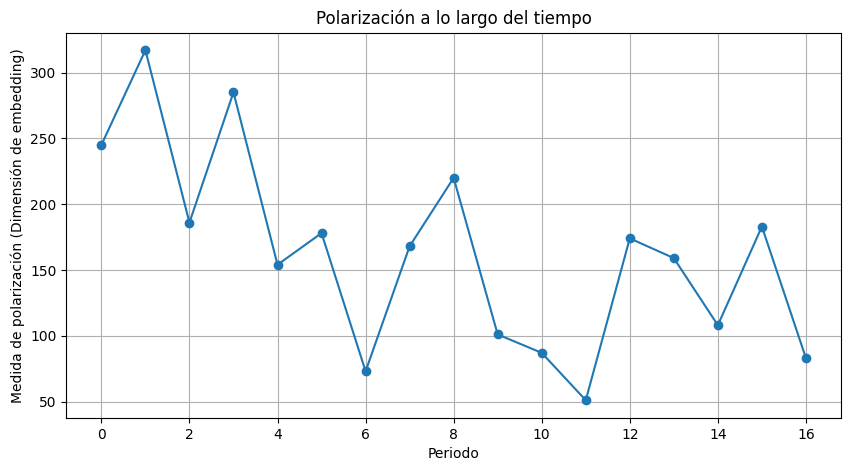

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(ed_3day[0], marker='o')
plt.xlabel('Periodo')
plt.ylabel('Medida de polarización (Dimensión de embedding)')
plt.title('Polarización a lo largo del tiempo')
plt.grid(True)
plt.show()

In [11]:
ed_5day = measure_polarization(graphs, steps=5, accum=False)
print(ed_5day)

Window 2025-02-23: Estimated embedding dimension = 397
Window 2025-02-28: Estimated embedding dimension = 413
Window 2025-03-05: Estimated embedding dimension = 332
Window 2025-03-10: Estimated embedding dimension = 242
Window 2025-03-15: Estimated embedding dimension = 194
Window 2025-03-20: Estimated embedding dimension = 289
Window 2025-03-25: Estimated embedding dimension = 120
Window 2025-03-30: Estimated embedding dimension = 215
Window 2025-04-04: Estimated embedding dimension = 226
Window 2025-04-09: Estimated embedding dimension = 247
([397, 413, 332, 242, 194, 289, 120, 215, 226, 247], [('2025-02-23', '2025-02-27'), ('2025-02-28', '2025-03-04'), ('2025-03-05', '2025-03-09'), ('2025-03-10', '2025-03-14'), ('2025-03-15', '2025-03-19'), ('2025-03-20', '2025-03-24'), ('2025-03-25', '2025-03-29'), ('2025-03-30', '2025-04-03'), ('2025-04-04', '2025-04-08'), ('2025-04-09', '2025-04-13')])


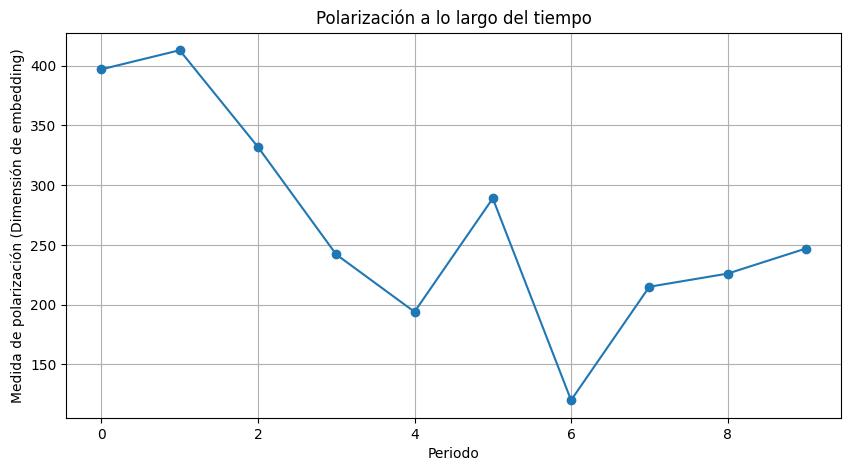

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(ed_5day[0], marker='o')
plt.xlabel('Periodo')
plt.ylabel('Medida de polarización (Dimensión de embedding)')
plt.title('Polarización a lo largo del tiempo')
plt.grid(True)
plt.show()

In [13]:
ed_7day = measure_polarization(graphs, steps=7, accum=False)
print(ed_7day)

Window 2025-02-23: Estimated embedding dimension = 664
Window 2025-03-02: Estimated embedding dimension = 389
Window 2025-03-09: Estimated embedding dimension = 333
Window 2025-03-16: Estimated embedding dimension = 381
Window 2025-03-23: Estimated embedding dimension = 212
Window 2025-03-30: Estimated embedding dimension = 332
Window 2025-04-06: Estimated embedding dimension = 334
([664, 389, 333, 381, 212, 332, 334], [('2025-02-23', '2025-03-01'), ('2025-03-02', '2025-03-08'), ('2025-03-09', '2025-03-15'), ('2025-03-16', '2025-03-22'), ('2025-03-23', '2025-03-29'), ('2025-03-30', '2025-04-05'), ('2025-04-06', '2025-04-12')])


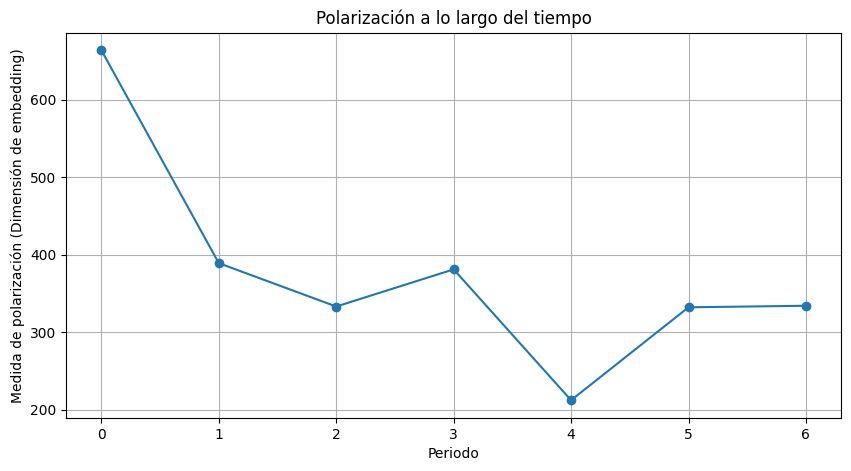

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(ed_7day[0], marker='o')
plt.xlabel('Periodo')
plt.ylabel('Medida de polarización (Dimensión de embedding)')
plt.title('Polarización a lo largo del tiempo')
plt.grid(True)
plt.show()

In [15]:
ed_10day = measure_polarization(graphs, steps=10, accum=False)
print(ed_10day)

Window 2025-02-23: Estimated embedding dimension = 777
Window 2025-03-05: Estimated embedding dimension = 546
Window 2025-03-15: Estimated embedding dimension = 468
Window 2025-03-25: Estimated embedding dimension = 321
Window 2025-04-04: Estimated embedding dimension = 441
([777, 546, 468, 321, 441], [('2025-02-23', '2025-03-04'), ('2025-03-05', '2025-03-14'), ('2025-03-15', '2025-03-24'), ('2025-03-25', '2025-04-03'), ('2025-04-04', '2025-04-13')])


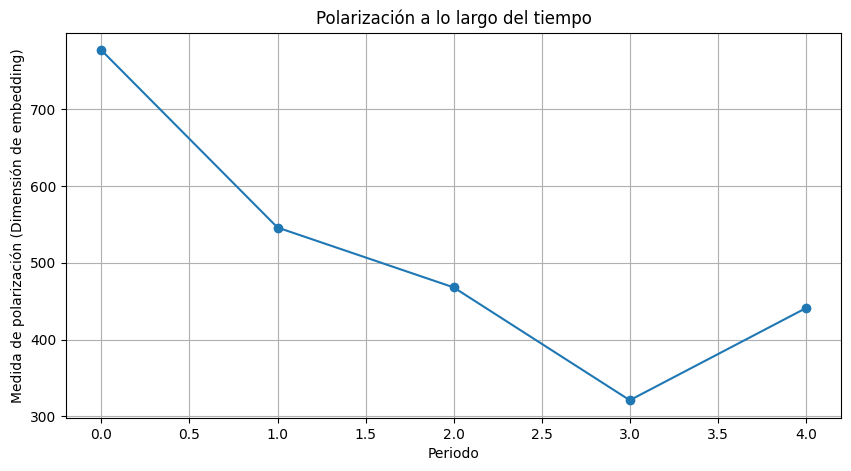

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(ed_10day[0], marker='o')
plt.xlabel('Periodo')
plt.ylabel('Medida de polarización (Dimensión de embedding)')
plt.title('Polarización a lo largo del tiempo')
plt.grid(True)
plt.show()

In [24]:
ed_total_accum = measure_polarization(graphs, steps=len(date_strings), accum=True)
print(ed_total_accum)

Accumulated Window up to 2025-04-15: Estimated embedding dimension = 2069
([2069], [('2025-02-23', '2025-04-15')])
